In [5]:
import os, sys
from pathlib import Path
import loader 
import utils
from torch.utils.data import DataLoader
import torch 
import torchvision
# --------------------------- load Parameters from config ----------------------------------
config_path = os.path.join(Path.cwd(),'models\\VisionTransformer\\config.yaml')
params = utils.get_config_from_yaml(config_path)


# the dataset is set up he coppes images out of the original image i the set size 
# each epoch he takes a new slice of the original image 
# recomended sizes [64,64] / [128,128] / [256, 256]  
HE_img_dir = os.path.join(params['train_dir'],'HE')
IHC_img_dir = os.path.join(params['train_dir'],'IHC')
           
num_patches = (1024 * 1024) // params['img_size'][0]**2 


train_data = loader.stain_transfer_dataset( img_patch=  1,
                                            params= params,
                                            HE_img_dir = HE_img_dir,
                                            IHC_img_dir = IHC_img_dir,                                                     
                                           )
            
# get dataloader
train_data_loader = DataLoader(train_data, batch_size=1, shuffle=False) 

            
real_HE, real_IHC,img_name = next(iter(train_data_loader))
contrast_IHC = torchvision.transforms.functional.adjust_contrast(real_IHC,3)


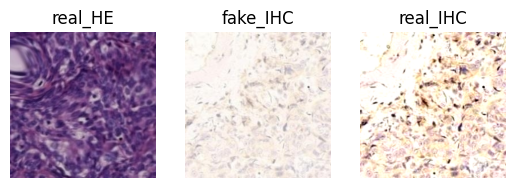

In [6]:

utils.plot_img_set(real_HE, real_IHC, contrast_IHC, 3,params,img_name,'train',1)

In [7]:
from torchmetrics import StructuralSimilarityIndexMeasure
ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(params['device'])
print(ssim(contrast_IHC, real_IHC))

tensor(0.7442, device='cuda:0')


In [4]:
from torch import nn
class MSA(nn.Module):
    def __init__(self, d, num_heads=2):
        super(MSA, self).__init__()
        self.d = d
        self.num_heads = num_heads

        assert d % num_heads == 0, f"Can't divide dimension {d} into {num_heads} heads"

        d_head = int(d / num_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.num_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.num_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.num_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.num_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [5]:
from einops import rearrange
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [6]:
#-----------------------------------------------------------------------------------------------
# PATCH EMBEDDING
#-----------------------------------------------------------------------------------------------
class patch_embedding(nn.Module):
    def __init__(self, in_channels, patch_size):
        super().__init__()
# ---------- inputs -------------------
# [N, in_channels, in_height, in_width]
# in_channels ------> int: number of channels in 
# patch_size -------> [w,h] : size of patch
#
# ---------- output -------------------
# P = patch_dim = (patch_size**2)* in_channels
# D = lossles embedding_dim = (in_width/patch_size[0])**2
# [N, P, D]
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.patch_dim = (patch_size[0]**2)* in_channels

        assert patch_size[0] == patch_size[1], "patch_embedding is only for square patches"

        self.patcher = nn.Conv2d(   in_channels=in_channels,
                                    out_channels = self.patch_dim,
                                    kernel_size = patch_size[0],
                                    stride = patch_size[0],
                                    padding = 0)
        
        self.flatten = nn.Flatten(  start_dim=2, 
                                    end_dim=3)
        
    def forward(self, x):
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 

        return x_flattened

In [7]:
import numpy as np
#-----------------------------------------------------------------------------------------------
# POSITIONAL EMBEDDING
#-----------------------------------------------------------------------------------------------
def get_positional_Embeddings(sequence_length, embedding_dim):
    # the n variable is scalling the values in the positional embedding in the attention is all you need paper n=10000 was choosen 
    n = 10000
    result = torch.ones(sequence_length, embedding_dim)
    for i in range(sequence_length):
        for j in range(embedding_dim):
            result[i][j] = np.sin(i / (n ** (j / embedding_dim))) if j % 2 == 0 else np.cos(i / (n ** ((j - 1) / embedding_dim)))
    return result

In [14]:

patch_size = [16,16]
num_heads = 8
embedding_dim = int((256/16)**2)
x = real_HE

n, c, h, w = x.shape
patch_emb = patch_embedding(3,patch_size).to('cuda')
pos_embedding = nn.Parameter(torch.tensor(get_positional_Embeddings((16**2)* 3 , embedding_dim))).to('cuda')
#pos_embedding.requires_grad = False
pos_embed = pos_embedding.repeat(n, 1, 1)
patches = patch_emb(x)
ViT_in = patches + pos_embed

model = torch.nn.MultiheadAttention(embedding_dim , num_heads).to('cuda')


y=model(patches,patches,patches)
print(y) 

(tensor([[[ 0.0156, -0.0317,  0.0253,  ..., -0.0884,  0.0043, -0.0651],
         [-0.0684,  0.0767,  0.0453,  ...,  0.1692, -0.0437,  0.1810],
         [ 0.0031, -0.0570, -0.0221,  ..., -0.0791, -0.0165, -0.0838],
         ...,
         [-0.1026,  0.0484, -0.0233,  ...,  0.0303,  0.0430,  0.0932],
         [-0.0219, -0.0119, -0.0224,  ..., -0.0415,  0.0341, -0.0621],
         [-0.0140, -0.0303, -0.0057,  ..., -0.0927,  0.0198, -0.0528]]],
       device='cuda:0', grad_fn=<ViewBackward0>), tensor([[[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]],

        [[1.]]

C:\Users\phili\AppData\Local\Temp\ipykernel_2016\3526520040.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_embedding = nn.Parameter(torch.tensor(get_positional_Embeddings((16**2)* 3 , embedding_dim))).to('cuda')


In [4]:
from torch import nn
import torch 
x = torch.randn((1, 3072, 8, 8)).cuda()
x_1 = torch.randn((1, 3072, 64)).cuda()
model = nn.Conv2d(3072, 3, 1, 1, 0).cuda()
mlp = nn.Linear(64,64).cuda()
y_1 = mlp(x_1)
print(y_1.shape)
y = model(x)
print(y.shape)

torch.Size([1, 3072, 64])
torch.Size([1, 3, 8, 8])


In [ ]:
from U_net_pytorch import UNet
model = UNet(in_channels=params['in_channels'],out_channels=3, init_features=32).to(params['device'])
#model = U_net_Generator(in_channels=params['in_channels'], features=params['gen_features']).to(params['device'])

model_testing = eval.test_network(model,params,training_time)
model_testing.fit()

In [ ]:
def sample(self, model, n):
        #logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        
        return x
